In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 1.1 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


In [3]:
import yfinance as yf

In [4]:
stock_symbol = 'GAIL.NS'

In [5]:
data = yf.download(tickers = stock_symbol,period ='5y',interval ='1d')

[*********************100%***********************]  1 of 1 completed


In [6]:
type(data)

pandas.core.frame.DataFrame

In [7]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-12-18,121.975029,126.112534,118.962532,124.000031,100.664841,25651817
2017-12-19,124.125031,125.737534,122.400032,124.137527,100.776451,11376621
2017-12-20,124.525032,127.375031,124.250031,124.850029,101.354866,17112567
2017-12-21,125.500031,126.500031,124.587532,125.375031,101.781067,9272425
2017-12-22,125.425034,127.175034,125.150032,125.775032,102.105804,12435376


In [8]:
data.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-12-12,91.099998,93.400002,90.199997,92.800003,92.800003,15920076
2022-12-13,93.150002,94.000000,92.699997,93.250000,93.250000,11215454
2022-12-14,93.250000,96.300003,93.150002,96.000000,96.000000,22598875
2022-12-15,96.150002,98.400002,95.449997,97.349998,97.349998,28006772
2022-12-16,97.199997,100.199997,96.599998,96.750000,96.750000,35484499


In [9]:
opn = data[['Open']]

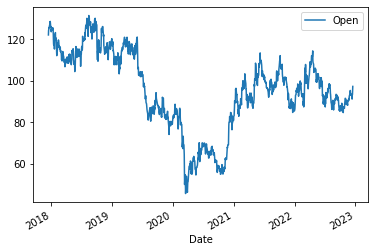

In [10]:
opn.plot()

In [11]:
import matplotlib.pyplot as plt

In [12]:
ds = opn.values

In [13]:
ds

array([[121.97502899],
       [124.12503052],
       [124.52503204],
       ...,
       [ 93.25      ],
       [ 96.15000153],
       [ 97.19999695]])

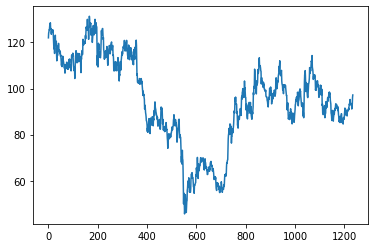

In [14]:
plt.plot(ds);

In [15]:
import numpy as np

In [16]:
from sklearn.preprocessing import MinMaxScaler

In [17]:
normalizer = MinMaxScaler(feature_range=(0,1))
ds_scaled = normalizer.fit_transform(np.array(ds).reshape(-1,1))

In [18]:
len(ds_scaled),len(ds)

(1235, 1235)

In [19]:
train_size = int(len(ds_scaled)*0.70)
test_size = len(ds_scaled)-train_size

In [20]:
train_size,test_size

(864, 371)

In [21]:
ds_train,ds_test = ds_scaled[0:train_size,:],ds_scaled[train_size:len(ds_scaled),:1]

In [22]:
len(ds_train),len(ds_test)

(864, 371)

In [23]:
#creating dataset in time series for LSTM
def create_ds(dataset,step):
    Xtrain,Ytrain = [],[]
    for i in range(len(dataset)-step-1):
        a = dataset[i:(i+step),0]
        Xtrain.append(a)
        Ytrain.append(dataset[i+step,0])
    return np.array(Xtrain),np.array(Ytrain)

In [24]:
#taking 100 days price as one record for training
time_stamp = 100
x_train,y_train = create_ds(ds_train,time_stamp)
x_test,y_test = create_ds(ds_test,time_stamp)

In [25]:
x_train.shape,y_train.shape

((763, 100), (763,))

In [26]:
x_test.shape,y_test.shape

((270, 100), (270,))

In [27]:
#reshaping data to fit into LSTM model
x_train =x_train.reshape(x_train.shape[0],x_train.shape[1],1)
x_test =x_test.reshape(x_test.shape[0],x_test.shape[1],1)


In [28]:
from keras.models import Sequential
from keras.layers import Dense,LSTM

In [29]:
#creating LSTM model using keras
model = Sequential()
model.add(LSTM(units=50,return_sequences=True,input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50,return_sequences=True))
model.add(LSTM(units=50))
model.add(Dense(units=1,activation='linear'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [30]:
#Training model with adam optimizer and mean squared error loss function
model.compile(loss='mean_squared_error',optimizer = 'adam')
model.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=100,batch_size=64)

Epoch 1/100
12/12 [==============================] - 19s 645ms/step - loss: 0.0798 - val_loss: 0.0066
Epoch 2/100
12/12 [==============================] - 3s 280ms/step - loss: 0.0160 - val_loss: 0.0123
Epoch 3/100
12/12 [==============================] - 2s 203ms/step - loss: 0.0094 - val_loss: 0.0043
Epoch 4/100
12/12 [==============================] - 2s 199ms/step - loss: 0.0064 - val_loss: 0.0032
Epoch 5/100
12/12 [==============================] - 2s 201ms/step - loss: 0.0048 - val_loss: 0.0034
Epoch 6/100
12/12 [==============================] - 2s 202ms/step - loss: 0.0044 - val_loss: 0.0032
Epoch 7/100
12/12 [==============================] - 2s 209ms/step - loss: 0.0043 - val_loss: 0.0030
Epoch 8/100
12/12 [==============================] - 2s 204ms/step - loss: 0.0042 - val_loss: 0.0029
Epoch 9/100
12/12 [==============================] - 2s 204ms/step - loss: 0.0040 - val_loss: 0.0029
Epoch 10/100
12/12 [==============================] - 2s 201ms/step - loss: 0.0040 - val_l

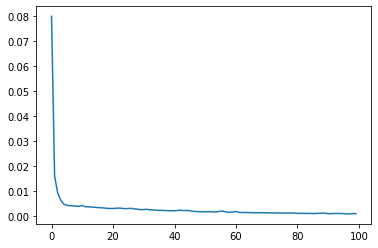

In [31]:
#plotting loss,it showsthat loss has decreased significantly and model trained well
loss = model.history.history['loss']
plt.plot(loss)

In [32]:
#Predicting on train and test data
train_predict = model.predict(x_train)
test_predict = model.predict(x_test)

9/9 [==============================] - 0s 36ms/step


In [33]:
#inverse transforn to get actual value
train_predict = normalizer.inverse_transform(train_predict)
test_predict = normalizer.inverse_transform(test_predict)

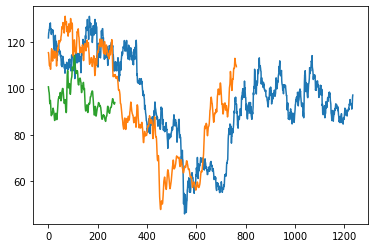

In [34]:
#comparing using visuals
plt.plot(normalizer.inverse_transform(ds_scaled))
plt.plot(train_predict)
plt.plot(test_predict)

In [35]:
type(train_predict)

numpy.ndarray

In [36]:
test = np.vstack((train_predict,test_predict))

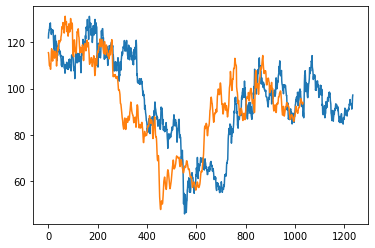

In [37]:
#combining the predicted data to creatye uniforn data visualization
plt.plot(normalizer.inverse_transform(ds_scaled))
plt.plot(test)

In [38]:
len(ds_test)

371

In [39]:
#getting  the last 100 days records
fut_inp = ds_test[270:]

In [41]:
fut_inp = fut_inp.reshape(1,-1)

In [42]:
tmp_inp = list(fut_inp)

In [44]:
#creating list of the last 100 days
tmp_inp = tmp_inp[0].tolist()

In [47]:
#Predicting next 30 days price suing the current data
#It will predict in sliding window manner (algorithm) with stride 1
lst_output=[]
n_steps=100
i=0
while(i<30):
    
    if(len(tmp_inp)>100):
        fut_inp = np.array(tmp_inp[1:])
        fut_inp=fut_inp.reshape(1,-1)
        fut_inp = fut_inp.reshape((1, n_steps, 1))
        yhat = model.predict(fut_inp, verbose=0)
        tmp_inp.extend(yhat[0].tolist())
        tmp_inp = tmp_inp[1:]
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        fut_inp = fut_inp.reshape((1, n_steps,1))
        yhat = model.predict(fut_inp, verbose=0)
        tmp_inp.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)
        

[[0.60503751039505], [0.6185694336891174], [0.6282083988189697], [0.6361008882522583], [0.6428959369659424], [0.6489161849021912], [0.6544719338417053], [0.6598613262176514], [0.6653321385383606], [0.6710647344589233], [0.6771669983863831], [0.683682382106781], [0.6906009316444397], [0.6978744864463806], [0.7054312229156494], [0.7131885290145874], [0.7210661172866821], [0.7289912700653076], [0.7369069457054138], [0.7447721362113953], [0.7525616884231567], [0.7602643370628357], [0.767880916595459], [0.7754174470901489], [0.7828852534294128], [0.7902953028678894], [0.7976568937301636], [0.8049765229225159], [0.8122568130493164], [0.8194976449012756]]


In [48]:
len(ds_scaled)


1235

In [49]:
#Creating a dummy plane to plot graph one after another
plot_new=np.arange(1,101)
plot_pred=np.arange(101,131)

In [51]:

ds_new = ds_scaled.tolist()

In [52]:
len(ds_new)


1235

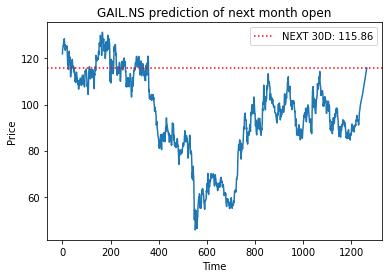

In [56]:
#Plotting final results with predicted value after 30 Days
plt.plot(final_graph,)
plt.ylabel("Price")
plt.xlabel("Time")
plt.title("{0} prediction of next month open".format(stock_symbol))
plt.axhline(y=final_graph[len(final_graph)-1], color = 'red', linestyle = ':', label = 'NEXT 30D: {0}'.format(round(float(*final_graph[len(final_graph)-1]),2)))
plt.legend()

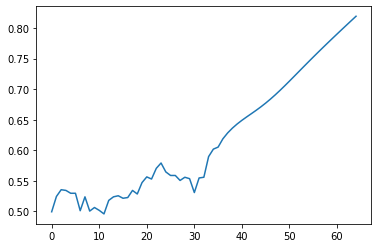

In [53]:
#Entends helps us to fill the missing value with approx value
ds_new.extend(lst_output)
plt.plot(ds_new[1200:])

In [54]:
#Creating final data for plotting
final_graph = normalizer.inverse_transform(ds_new).tolist()

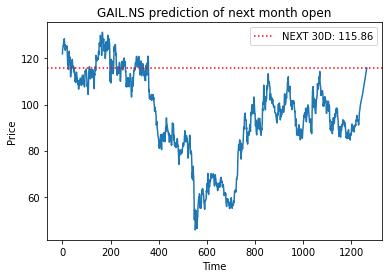

In [55]:
#Plotting final results with predicted value after 30 Days
plt.plot(final_graph,)
plt.ylabel("Price")
plt.xlabel("Time")
plt.title("{0} prediction of next month open".format(stock_symbol))
plt.axhline(y=final_graph[len(final_graph)-1], color = 'red', linestyle = ':', label = 'NEXT 30D: {0}'.format(round(float(*final_graph[len(final_graph)-1]),2)))
plt.legend()